In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os
import plotly.express as px
from matplotlib import cm
import matplotlib as mpl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import matplotlib as mpl
from matplotlib import cm
import numpy.ma as ma
import scipy.stats
import cartopy.crs as ccrs
import cartopy
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import random
import sklearn
import xarray as xr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pathos.threading import ThreadPool as Pool
from sklearn import datasets, linear_model
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
from scipy.stats import spearmanr

In [2]:
from global_correlations import *

In [3]:
work_dir=Path("/mnt/u/LSM root zone/global_sr")
out_dir=Path("/mnt/u/LSM root zone/global_sr/output")
fig_dir=Path('/mnt/c/Users/fransjevanoors/surfdrive - Fransje van Oorschot@surfdrive.surf.nl/Fransje/global_SR/global_sr_paper/figures')

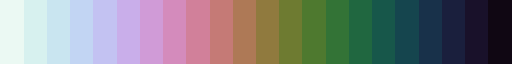

In [4]:
cmap = cm.get_cmap('cubehelix_r', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap_sr = ListedColormap(color_list[1:-1])
cmap_sr.set_over(color_list[-1])
cmap_sr.set_under(color_list[0])
cmap_sr.set_bad('whitesmoke')
cmap_sr

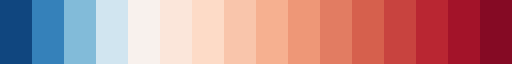

In [5]:
#cmap temperature
cmap = cm.get_cmap('RdBu_r', 26)
cl = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
blues = [cl[1],cl[4],cl[7],cl[10]]
reds = cl[13:25]
cmap_temp = ListedColormap(np.concatenate([blues,reds]))
cmap_temp.set_over(cl[-1])
cmap_temp.set_under(cl[0])
cmap_temp.set_bad('lightgrey')
cmap_temp

## gridded variables

In [11]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v2.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()

In [12]:
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/p_mean_gswp3_land.nc')
t = xr.open_dataset(f'{work_dir}/output/gridded_sr/t_mean_gswp3_land.nc')
idu = xr.open_dataset(f'{work_dir}/output/gridded_sr/idu_mean_land.nc')
# asi = xr.open_dataset(f'{work_dir}/output/gridded_sr/asi_land.nc')
p_days = xr.open_dataset(f'{work_dir}/output/gridded_sr/p_days_land.nc')
# lai = xr.open_dataset(f'{work_dir}/output/gridded_sr/lai_mean_land.nc')
slp = xr.open_dataset(f'{work_dir}/output/gridded_sr/slp_land.nc')

# change units of slope from degree to percent
rads = np.deg2rad(slp.Band1)
slp_perc = np.tan(rads) * 100
slp['perc'] = slp_perc

In [13]:
# mask out points outside catchment ranges
pmax = df.p_mean.max()
pmin = df.p_mean.min()
pl= xr.where(((p.pr>=pmin)&(p.pr<=pmax)), p.pr, np.nan)

tmax = df.t_mean.max()
tmin = df.t_mean.min()
tl= xr.where(((t.tas>=tmin)&(t.tas<=tmax)), t.tas, np.nan)

idumax = df.idu_mean.max()
idumin = df.idu_mean.min()
idul= xr.where(((idu.idu_mean>=idumin)&(idu.idu_mean<=idumax)), idu.idu_mean, np.nan)

slpmax = df.slp_mean.max()
slpmin = df.slp_mean.min()
slpl= xr.where(((slp.perc>=0)&(slp.perc<=slpmax)), slp.perc, np.nan)

# make one mask
pl = xr.where(((pl>=0)&(idul>=0)&(slpl>=0)&(tl>=-50)),pl,np.nan)
tl = xr.where(((pl>=0)&(idul>=0)&(slpl>=0)&(tl>=-50)),tl,np.nan)
idul = xr.where(((pl>=0)&(idul>=0)&(slpl>=0)&(tl>=-50)),idul,np.nan)
slpl = xr.where(((pl>=0)&(idul>=0)&(slpl>=0)&(tl>=-50)),slp,np.nan)

/tmp/ipykernel_470/3081540545.py:52: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlGnBu").copy()
  cmap.set_bad('whitesmoke')
/tmp/ipykernel_470/3081540545.py:71: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlOrRd").copy()
  cmap.set_bad('whitesmoke')


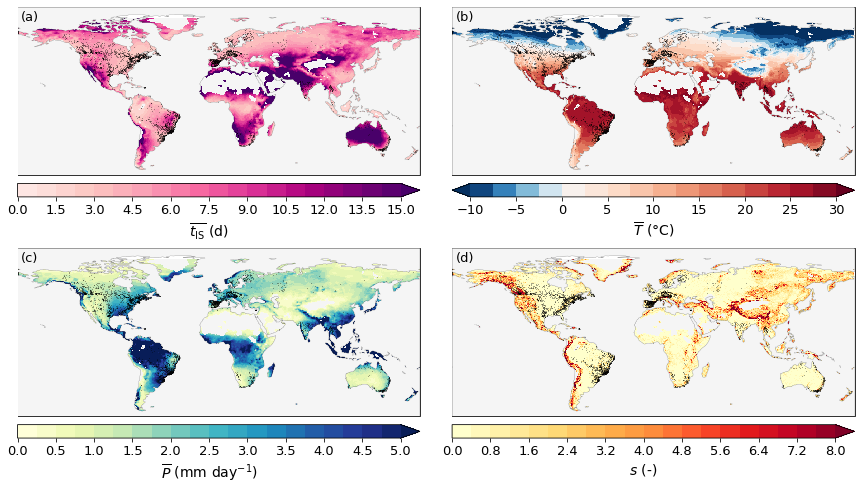

In [14]:
# mask out values outside range
fig2 = plt.figure(figsize=(15,15))
ax = fig2.add_subplot(221,projection=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.08,hspace=-0.58)

# idu mean
lvls = np.linspace(0,15,21)
lvls2 = np.linspace(0,15,11)
cmap = cm.get_cmap('RdPu',23)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmap = ListedColormap(color_list[2:])
cmap.set_bad('whitesmoke')
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (idul[:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
cbar.set_label('$\overline{t_\mathrm{IS}}$ (d)',size=14)
cbar.ax.tick_params(axis='x', labelsize=13)
ax.text(-177,78,'(a)',size=13,zorder=101)
ax.set_title('')

# t mean
lvls = np.linspace(-10,30,17)
lvls2 = np.linspace(-10,30,17)
cmap = cmap_temp
cmap.set_bad('whitesmoke')
tl[0,0,0]=-15
tl[0,0,1]=35
ax = fig2.add_subplot(222,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
# ax.plot(df.lon,df.lat,marker='o',markeredgecolor='k',markerfacecolor=None,markeredgewidth=0.1,markersize=0.5,linestyle='None',zorder=101)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (tl[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls,add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='both', pad=0.015,aspect=30)
cbar.set_label('$\overline{T}$ ($\degree$C)',size=14)
cbar.ax.tick_params(axis='x', labelsize=13)
ax.set_title('')
ax.text(-177,78,'(b)',size=13,zorder=101)

# p mean
lvls = np.linspace(0,5,21)
lvls2 = np.linspace(0,5,11)
cmap = cm.get_cmap('YlGnBu')
cmap.set_bad('whitesmoke')
ax = fig2.add_subplot(223,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (pl[0,:,:]).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal', spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
ax.text(-177,78,'(c)',size=13,zorder=101)
ax.set_title('')
cbar.set_label('$\overline{P}$ ($\mathrm{mm}$ $\mathrm{day}^{-1}$)',size=14)
cbar.ax.tick_params(axis='x', labelsize=13)

# slp mean
lvls = np.linspace(0,8,21)
lvls2 = np.linspace(0,8,11)
cmap = cm.get_cmap('YlOrRd')
cmap.set_bad('whitesmoke')
ax = fig2.add_subplot(224,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
ax.plot(df.lon,df.lat,marker='x',markeredgecolor=(0,0,0,0.6),markerfacecolor=None,markersize=0.2,linestyle='None',zorder=101)
a = (slpl.perc).plot(ax=ax, cmap=cmap,levels=lvls, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.015,aspect=30,ticks=lvls2)
cbar.set_label('$s$ (-)',size=14)
cbar.ax.tick_params(axis='x', labelsize=13)
ax.text(-177,78,'(d)',size=13,zorder=101)
ax.set_title('')
fig2.savefig(f'{out_dir}/gridded_sr/figures/4_variables_maps.jpg',bbox_inches='tight',dpi=600)
fig2.savefig(f'{fig_dir}/fig03.jpg',bbox_inches='tight',dpi=600)


## Apply RF to gridded data

In [15]:
min_samples_leaf=1
max_depth=None
data_sources = 'gswp-p_gleam-ep_gswp-t'

In [16]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
df['catch_id'] = df.index
features = ['idu_mean','t_mean','p_mean','slp_mean']

In [17]:
sr_rp = 'sr_20'
ll = ['lat','lon','catch_id']
f = features + ll
dfx = df[f].values
dfy = df[sr_rp].values

# here split dataset into 'temp' and 'test'
cv_outer = 5 # the number of outer cross validations
sdf = pd.DataFrame(index=range(cv_outer), columns=['n_estimators','max_depth','min_samples_leaf','max_features','train_mae','train_r2_adj','test_mae','test_r2_adj','n_train','n_test','fold'])
l = []
train_dfs=[]
test_dfs=[]

kf = KFold(n_splits=cv_outer,shuffle=True,random_state=0)
df = dfy.reshape(-1, 1).ravel()
i=0
cv_train_ix = []
cv_test_ix = []
ddl = []
for train_ix, test_ix in kf.split(dfx):
    cv_train_ix.append(train_ix)
    cv_test_ix.append(test_ix)
    X = dfx[train_ix]
    y = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix] 
    
    # save lat lon columns
    lat_train = X[:,-3]
    lon_train = X[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X[:,-1]
    catch_id_test = X_test[:,-1]

    # remove lat lon catchid columns
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X = np.delete(X,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)  
    
    # run rf model with full 'temp' set and test set using the best inner cross validation
    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,max_depth=max_depth,min_samples_leaf=min_samples_leaf,oob_score=True)
    rf.fit(X,y)
    test_y_pred = rf.predict(X_test)
    train_y_pred = rf.predict(X)
    n_train,n_test = len(y),len(y_test)

    train_mae = np.round(mean_absolute_error(y, train_y_pred),2)
    test_mae = np.round(mean_absolute_error(y_test, test_y_pred),2)
    
    perm_importance = permutation_importance(rf, X_test, y_test,scoring='neg_mean_absolute_error',random_state=42)
    pi = perm_importance.importances_mean
    dd = pd.DataFrame(index=features,columns=['pi'])
    dd.pi = pi
    ddl.append(dd)
    
    df_train = pd.DataFrame(index=catch_id_train,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_train['lat'] = lat_train
    df_train['lon'] = lon_train
    df_train['Sr_m'] = y
    df_train['Sr_p'] = train_y_pred
    df_train['Sr_p-Sr_m'] = train_y_pred - y
    df_train['(Sr_p-Sr_m)/Sr_m'] = (train_y_pred - y)/train_y_pred
    train_dfs.append(df_train)

    df_test = pd.DataFrame(index=catch_id_test,columns=['lat','lon','Sr_m','Sr_p','Sr_p-Sr_m','(Sr_p-Sr_m)/Sr_m'])
    df_test['lat'] = lat_test
    df_test['lon'] = lon_test
    df_test['Sr_m'] = y_test
    df_test['Sr_p'] = test_y_pred
    df_test['Sr_p-Sr_m'] = test_y_pred - y_test
    df_test['(Sr_p-Sr_m)/Sr_m'] = (test_y_pred - y_test)/test_y_pred
    test_dfs.append(df_test)

    i+=1

test_dfs = pd.concat(test_dfs)
train_dfs = pd.concat(train_dfs)

In [18]:
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/p_mean_gswp3_land.nc')
t = xr.open_dataset(f'{work_dir}/output/gridded_sr/t_mean_gswp3_land.nc')
idu = xr.open_dataset(f'{work_dir}/output/gridded_sr/idu_mean_land.nc')
slp = xr.open_dataset(f'{work_dir}/output/gridded_sr/slp_land.nc')

p_array = p.pr.to_numpy().flatten()
t_array = t.tas.to_numpy().flatten()
idu_array = idu.idu_mean.to_numpy().flatten()
slp_array = slp.Band1.to_numpy().flatten()

lat_array = []
lon_array = []
for m in range(len(p.lat.values)):
    for n in range(len(p.lon.values)):
        lat_array.append(p.lat.values[m])
        lon_array.append(p.lon.values[n])

In [19]:
df = pd.read_csv(f'{work_dir}/output/catchment_characteristics/master_characteristics_{data_sources}_v3.csv',index_col=0)
df = df.drop(columns=['ppd_l'])
df = df[df.p_mean-df.q_mean < df.ep_mean]
df = df[['p_mean','ep_mean', 't_mean','tdiff_mean','idu_mean', 'si_ep','si_p', 'asi','dtb','ia','slp_mean','el_mean','tc','ntc','nonveg','pclay','psand','lai_mean','lai_rsd','sc_mean','sc_rsd','sr_20','lat','lon']]
df = df.dropna()
features = ['p_mean','t_mean','idu_mean','slp_mean']

dfs=[]

for i in range(5):
    sr_rp = 'sr_20'
    df['catch_id'] = df.index
    ll = ['lat','lon','catch_id']
    f = features + ll
    dfx = df[f].values
    dfy = df[sr_rp].values
    train_ix = cv_train_ix[i]
    test_ix = cv_test_ix[i]

    X_train = dfx[train_ix]
    y_train = dfy[train_ix]
    X_test = dfx[test_ix]
    y_test = dfy[test_ix]

    # save lat lon columns
    lat_train = X_train[:,-3]
    lon_train = X_train[:,-2]
    lat_test = X_test[:,-3]
    lon_test = X_test[:,-2]
    catch_id_train = X_train[:,-1]
    catch_id_test = X_test[:,-1]
    # remove lat lon columns
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_train = np.delete(X_train,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)
    X_test = np.delete(X_test,-1,1)

    rf = RandomForestRegressor(criterion='absolute_error',random_state=42,min_samples_leaf=min_samples_leaf,max_depth=max_depth)
    rf = rf.fit(X_train, y_train)
    train_y_pred = rf.predict(X_train)
    
    dfg = pd.DataFrame(index=np.arange(0,195840,1), columns=['lat','lon','p_mean','t_mean','idu_mean','slp_mean'])
    dfg.loc[:,'lat'] = lat_array
    dfg.loc[:,'lon'] = lon_array
    dfg.loc[:,'p_mean'] = p_array
    dfg.loc[:,'t_mean'] = t_array
    dfg.loc[:,'idu_mean'] = idu_array
    dfg.loc[:,'slp_mean'] = slp_array
    dfg = dfg.dropna()
    
    dfx = dfg[features].values
    test_y_pred = rf.predict(dfx)
    dfg['sr_pred'] = test_y_pred
    dfs.append(dfg)

In [20]:
df0 = dfs[0]
df1 = dfs[1]
df2 = dfs[2]
df3 = dfs[3]
df4 = dfs[4]

In [21]:
dfp = pd.DataFrame(index=np.arange(0,195840,1), columns=['lat','lon','sr_p0','sr_p1','sr_p2','sr_p3','sr_p4'])
dfp.loc[:,'lat'] = lat_array
dfp.loc[:,'lon'] = lon_array
dfp['sr_p0'] = df0['sr_pred']
dfp['sr_p1'] = df1['sr_pred']
dfp['sr_p2'] = df2['sr_pred']
dfp['sr_p3'] = df3['sr_pred']
dfp['sr_p4'] = df4['sr_pred']
dfp['sr_p_mean'] = dfp[['sr_p0','sr_p1','sr_p2','sr_p3','sr_p4']].mean(axis=1)
dfp['sr_p_std'] = dfp[['sr_p0','sr_p1','sr_p2','sr_p3','sr_p4']].std(axis=1)
dfp['sr_p_sm'] = dfp['sr_p_std']/dfp['sr_p_mean']
dfp

,lat,lon,sr_p0,sr_p1,sr_p2,sr_p3,sr_p4,sr_p_mean,sr_p_std,sr_p_sm
0,80.0,-180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,80.0,-179.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80.0,-179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80.0,-178.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80.0,-178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
195835,-55.5,177.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195836,-55.5,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195837,-55.5,178.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195838,-55.5,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# dataframe to 2d xarray
# mean
srp = np.zeros([len(p.lat.values),len(p.lon.values)])
i=0
for n in range(len(p.lat.values)):
    for m in range(len(p.lon.values)):
        srp[n,m] = dfp['sr_p_mean'][i]
        i+=1
lon = p.lon.values
lat = p.lat.values
data_xr_mean = xr.DataArray(srp,
                       coords={'lat':lat,'lon':lon},
                       dims=['lat','lon'],
                       name='sr_p')

# std
srp = np.zeros([len(p.lat.values),len(p.lon.values)])
i=0
for n in range(len(p.lat.values)):
    for m in range(len(p.lon.values)):
        srp[n,m] = dfp['sr_p_std'][i]
        i+=1
lon = p.lon.values
lat = p.lat.values
data_xr_std = xr.DataArray(srp,
                       coords={'lat':lat,'lon':lon},
                       dims=['lat','lon'],
                       name='sr_p')

# std/mean
srp = np.zeros([len(p.lat.values),len(p.lon.values)])
i=0
for n in range(len(p.lat.values)):
    for m in range(len(p.lon.values)):
        srp[n,m] = dfp['sr_p_sm'][i]
        i+=1
lon = p.lon.values
lat = p.lat.values
data_xr_sm = xr.DataArray(srp,
                       coords={'lat':lat,'lon':lon},
                       dims=['lat','lon'],
                       name='sr_p')

In [23]:
# mask output
data_xr_mean = data_xr_mean.where(pl[0,:,:]>=0)
data_xr_std = data_xr_std.where(pl[0,:,:]>=0)
data_xr_sm = data_xr_sm.where(pl[0,:,:]>=0)

data_xr_mean.to_netcdf(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')

/tmp/ipykernel_470/46742766.py:26: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap_sr1.set_bad('lightgrey')


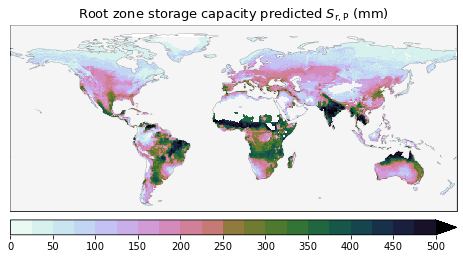

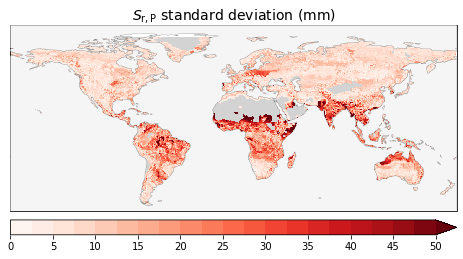

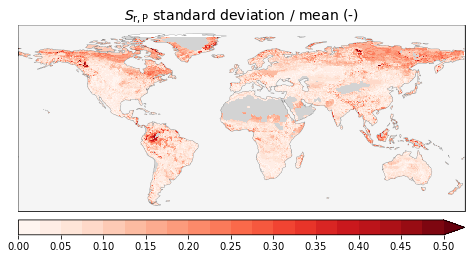

In [24]:
# sr predicted mean
bounds = np.linspace(0, 500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = data_xr_mean[:,:].plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='',size=10)
ax.set_title('Root zone storage capacity predicted $S_\mathrm{r,P}$ (mm)',size=13)
fig2.savefig(f'{out_dir}/gridded_sr/figures/sr_predicted_mean.jpg',bbox_inches='tight',dpi=600, transparent=True)

# standard deviation
from matplotlib import cm
cmap_sr1 = cm.get_cmap('Reds')
bounds = np.linspace(0,50,21)
bounds2 = np.linspace(0,50,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr1.N)
cmap_sr1.set_bad('lightgrey')

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = data_xr_std[:,:].plot(ax=ax, cmap=cmap_sr1,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='', size=10)
ax.set_title('$S_\mathrm{r,P}$ standard deviation (mm)',size=14)
fig2.savefig(f'{out_dir}/gridded_sr/figures/sr_predicted_std.jpg',bbox_inches='tight',dpi=300)

# relative standard deviation
bounds = np.linspace(0,0.5,21)
bounds2 = np.linspace(0,0.5,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr1.N)

fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
a = data_xr_sm[:,:].plot(ax=ax, cmap=cmap_sr1,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, orientation='horizontal',spacing='proportional',extend='max', pad=0.02,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='', size=10)
ax.set_title('$S_\mathrm{r,P}$ standard deviation / mean (-)',size=14)
fig2.savefig(f'{out_dir}/gridded_sr/figures/sr_predicted_std_mean.jpg',bbox_inches='tight',dpi=300)


## REFERENCE ROOT PRODUCTS

## all maps

In [8]:
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')

f = xr.open_dataset(f'{work_dir}/data/reference_sr/fan/maxroot_allregions_crugrid2.nc') 
f = f.root_depth
f = f.where(p.sr_p[:,:]>=0)

ya = xr.open_dataset(f'{work_dir}/data/reference_sr/yang/data/Effective_Rooting_Depth.nc')
ya = ya.Band1
ya = ya.where(p.sr_p[:,:]>=0)

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_20yrs.nc')
l = l.sr_cru_20yrs[0]
l = l.where(p.sr_p[:,:]>=0)

s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_cru_grid.nc')
s = s.cwdx80
s = s.where(p.sr_p[:,:]>=0)

sc = xr.open_dataset(f'{work_dir}/data/reference_sr/schenk2009/data/processed/95ecosys_rootdepth_1d_crugrid.nc') 
sc = sc['95ecosys_rootdepth_1d'][0]
sc = sc.where(p.sr_p[:,:]>=0)

ka = xr.open_dataset(f'{work_dir}/data/reference_sr/Kleidon rooting depth/rootAssMap150_crugrid.nc')
ka = ka['rootAssMap150_m']
ko = xr.open_dataset(f'{work_dir}/data/reference_sr/Kleidon rooting depth/rootOptMap150_crugrid.nc')
ko = ko['rootOptMap150_m']
ko = ko.where(p.sr_p[:,:]>=0)

#Schenk and Jackson observed rooting depths
sj = pd.read_csv(f'{work_dir}/data/reference_sr/Schenk+Jackson2003-rootzone-point-data.csv',index_col=0,delimiter=';')
lats = sj.Latitude.values
lons = sj.Longitude.values

# get unique values
sj = sj[['Latitude','Longitude','D50','D95',' D50_extrapolated','D95_extrapolated']]
ll=[]
for i in range(len(lats)):
    a = lats[i]
    b = lons[i]
    c = f'{a}_{b}'
    ll.append(c)
sj.index = ll
sjj = sj.groupby(level=0).agg('mean')

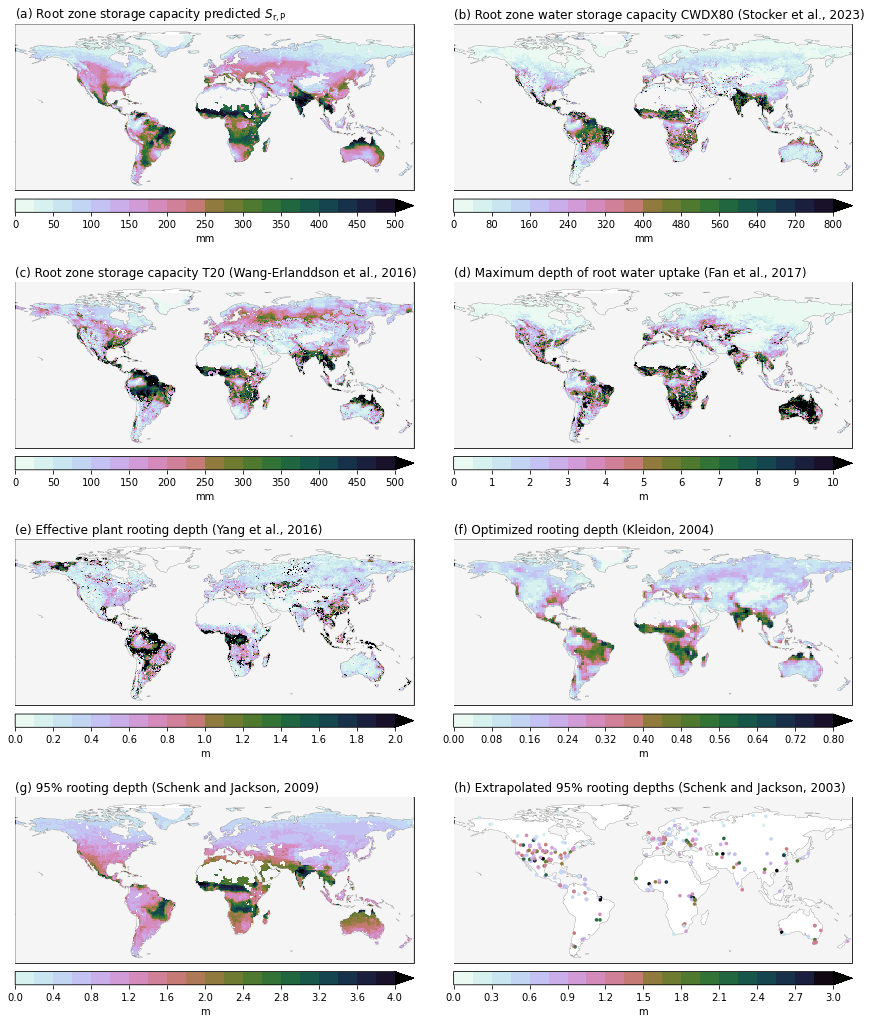

In [9]:
# single figure of maps
fig, ax = plt.subplots(4,2,figsize=(15,30),subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(hspace=-0.7,wspace=0.1)

for i in range(4):
    for j in range(2):
        m,n = i,j
        ax[m,n].coastlines(linewidth=0.1)
        ax[m,n].add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax[m,n].set_global()
        ax[m,n].set_xlim(-180,180)
        ax[m,n].set_ylim(-60,90)

# Sr predicted
bounds = np.linspace(0, 500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = p.sr_p.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm',size=10)
ax[m,n].set_title('')
ax[m,n].set_title('(a) Root zone storage capacity predicted $S_\mathrm{r,P}$',size=12, loc='left')

# Sr Stocker
bounds = np.linspace(0, 800,21)
bounds2 = np.linspace(0,800,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,1
a = s.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm',size=10)
ax[m,n].set_title('')
ax[m,n].set_title(f'(b) Root zone water storage capacity CWDX80 (Stocker et al., 2023)',size=12, loc='left')

# Sr Lan
bounds = np.linspace(0,500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,0
a = l.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm',size=10)
ax[m,n].set_title('(c) Root zone storage capacity T20 (Wang-Erlanddson et al., 2016)',size=12, loc='left')

# Fan
bounds = np.linspace(0,10,21)
bounds2 = np.linspace(0,10,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,1
a = f.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m',size=10)
ax[m,n].set_title('')
ax[m,n].set_title('(d) Maximum depth of root water uptake (Fan et al., 2017)',size=12, loc='left')

# Yang
bounds = np.linspace(0,2,21)
bounds2 = np.linspace(0,2,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=2,0
a = ya.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m',size=10)
ax[m,n].set_title('')
ax[m,n].set_title('(e) Effective plant rooting depth (Yang et al., 2016)',size=12, loc='left')


# root depth opt Kleidon
bounds = np.linspace(0,0.8,21)
bounds2 = np.linspace(0,0.8,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=2,1
a = ko.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a,ax=ax[m,n], orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax[m,n].set_title('')
ax[m,n].set_title('(f) Optimized rooting depth (Kleidon, 2004)',size=12, loc='left')

# Schenk 2009
bounds = np.linspace(0,4,21)
bounds2 = np.linspace(0,4,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=3,0
a = sc.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a,ax=ax[m,n], orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax[m,n].set_title('(g) 95% rooting depth (Schenk and Jackson, 2009)',size=12, loc='left')

# Schenk points
bounds = np.linspace(0,3,21)
bounds2 = np.linspace(0,3,11)
m,n=3,1
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
sp = ax[m,n].scatter(sjj.Longitude,sjj.Latitude,s=12,c=sjj.D95_extrapolated,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(sp, ax=ax[m,n], orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax[m,n].set_title('(h) Extrapolated 95% rooting depths (Schenk and Jackson, 2003)',size=12, loc='left')

fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_all_maps.jpg',bbox_inches='tight',dpi=600)


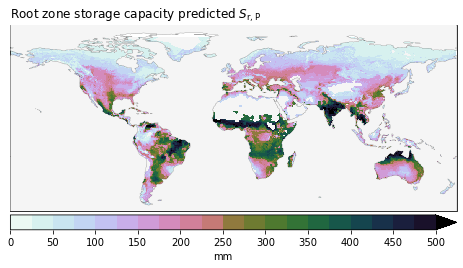

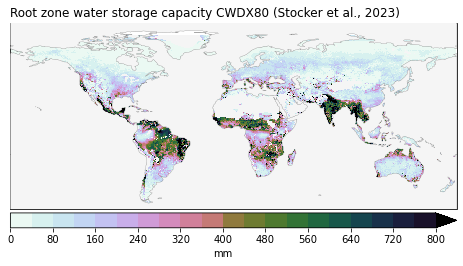

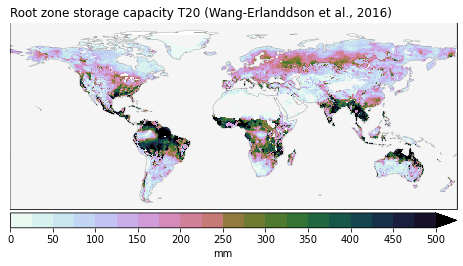

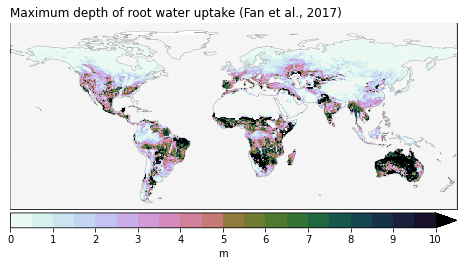

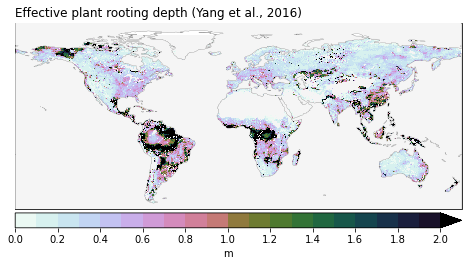

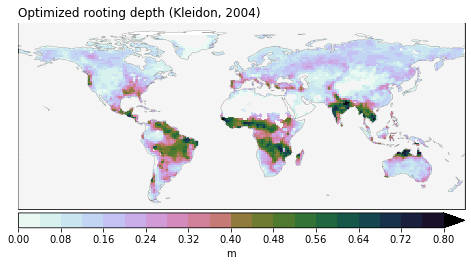

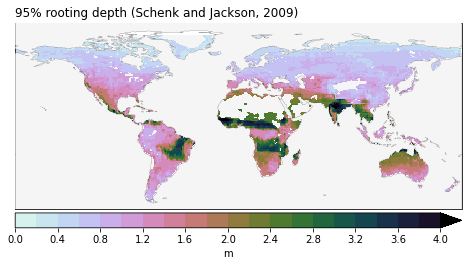

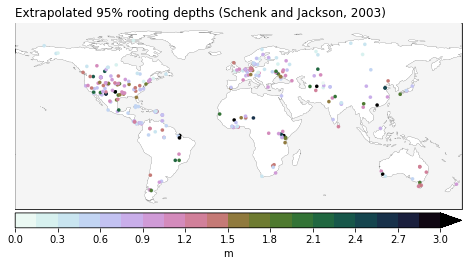

In [10]:
# single figure of maps
fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
m,n=0,0
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
# Sr predicted
bounds = np.linspace(0, 500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = p.sr_p.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax,orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm',size=10)
ax.set_title('')
ax.set_title('Root zone storage capacity predicted $S_\mathrm{r,P}$',size=12, loc='left')
fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_srp.jpg',bbox_inches='tight',dpi=600)


# Sr Stocker
fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
m,n=0,0
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
bounds = np.linspace(0, 800,21)
bounds2 = np.linspace(0,800,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = s.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax,orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm',size=10)
ax.set_title('')
ax.set_title(f'Root zone water storage capacity CWDX80 (Stocker et al., 2023)',size=12, loc='left')
fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_s23.jpg',bbox_inches='tight',dpi=600)


fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
m,n=0,0
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
# Sr Lan
bounds = np.linspace(0,500,21)
bounds2 = np.linspace(0,500,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = l.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax,orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='mm',size=10)
ax.set_title('Root zone storage capacity T20 (Wang-Erlanddson et al., 2016)',size=12, loc='left')
fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_w16.jpg',bbox_inches='tight',dpi=600)


# Fan
fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
m,n=0,0
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
bounds = np.linspace(0,10,21)
bounds2 = np.linspace(0,10,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = f.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax,orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m',size=10)
ax.set_title('')
ax.set_title('Maximum depth of root water uptake (Fan et al., 2017)',size=12, loc='left')
fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_f17.jpg',bbox_inches='tight',dpi=600)


# Yang
fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
m,n=0,0
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
bounds = np.linspace(0,2,21)
bounds2 = np.linspace(0,2,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = ya.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax,orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m',size=10)
ax.set_title('')
ax.set_title('Effective plant rooting depth (Yang et al., 2016)',size=12, loc='left')
fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_y16.jpg',bbox_inches='tight',dpi=600)


# root depth opt Kleidon
fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
m,n=0,0
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
bounds = np.linspace(0,0.8,21)
bounds2 = np.linspace(0,0.8,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = ko.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a,ax=ax, orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax.set_title('')
ax.set_title('Optimized rooting depth (Kleidon, 2004)',size=12, loc='left')
fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_k04.jpg',bbox_inches='tight',dpi=600)


# Schenk 2009
fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
m,n=0,0
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
bounds = np.linspace(0,4,21)
bounds2 = np.linspace(0,4,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = sc.plot(ax=ax, cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a,ax=ax, orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax.set_title('95% rooting depth (Schenk and Jackson, 2009)',size=12, loc='left')
fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_s09.jpg',bbox_inches='tight',dpi=600)


# Schenk points
fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection': ccrs.PlateCarree()})
m,n=0,0
ax.coastlines(linewidth=0.1)
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
bounds = np.linspace(0,3,21)
bounds2 = np.linspace(0,3,11)
m,n=0,0
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
sp = ax.scatter(sjj.Longitude,sjj.Latitude,s=12,c=sjj.D95_extrapolated,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(sp, ax=ax, orientation='horizontal',spacing='proportional',extend='max', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='m', size=10)
ax.set_title('Extrapolated 95% rooting depths (Schenk and Jackson, 2003)',size=12, loc='left')
fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_sj03.jpg',bbox_inches='tight',dpi=600)




## all maps normalized

In [11]:
# min and (max-min) for normalization - limit maximum values to 0.99 or 0.95 percentiles
pp = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
ppp = xr.where(pp.sr_p>pp.sr_p.quantile(0.99),pp.sr_p.quantile(0.99),pp.sr_p)
pmax = ppp.max().values 
pmin = ppp.min().values
p = (ppp - pmin) / (pmax-pmin)
t_srp = [100,200,300,400]
tll_srp = ['100 mm','200 mm','300 mm','400 mm']
tl_srp = (t_srp - pmin) / (pmax-pmin)

f = xr.open_dataset(f'{work_dir}/data/reference_sr/fan/maxroot_allregions_crugrid2.nc') 
f = xr.where(f.root_depth>f.root_depth.quantile(0.99),f.root_depth.quantile(0.99),f.root_depth)
fmin = f.min().values
fmax = f.max().values
f = (f-f.min())/(f.max()-f.min())
f = f.where(pp.sr_p[:,:]>=0)
t_f = [4,8,12,16]
tll_f = ['4 m','8 m','12 m','16 m']
tl_f = (t_f - fmin)/(fmax-fmin)

ya = xr.open_dataset(f'{work_dir}/data/reference_sr/yang/data/Effective_Rooting_Depth.nc')
ya = xr.where(ya.Band1>ya.Band1.quantile(0.95),ya.Band1.quantile(0.95),ya.Band1)
ymin = ya.min().values
ymax = ya.max().values
ya = (ya-ya.min())/(ya.max()-ya.min())
ya = ya.where(pp.sr_p[:,:]>=0)
t_y = [0.5,1,1.5,2,2.5]
tll_y = ['0.5 m','1 m','1.5 m','2 m','2.5 m']
tl_y = (t_y - ymin)/(ymax-ymin)

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_20yrs.nc')
l = xr.where(l.sr_cru_20yrs[0]>l.sr_cru_20yrs[0].quantile(0.99),l.sr_cru_20yrs[0].quantile(0.99),l.sr_cru_20yrs[0])
lmin = l.min().values
lmax = l.max().values
l = (l-l.min())/(l.max()-l.min())
l = l.where(pp.sr_p[:,:]>=0)
t_l = [200,400,600]
tll_l = ['200 mm','400 mm','600 mm']
tl_l = (t_l - lmin)/(lmax-lmin)

s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_cru_grid.nc')
s = xr.where(s.cwdx80>s.cwdx80.quantile(0.99),s.cwdx80.quantile(0.99),s.cwdx80)
smin = s.min().values
smax = s.max().values
s = (s-s.min())/(s.max()-s.min())
s = s.where(pp.sr_p[:,:]>=0)
t_s = [200,400,600,800]
tll_s = ['200 mm','400 mm','600 mm','800 mm']
tl_s = (t_s - smin)/(smax-smin)

sc = xr.open_dataset(f'{work_dir}/data/reference_sr/schenk2009/data/processed/95ecosys_rootdepth_1d_crugrid.nc') 
sc = sc.where(sc['95ecosys_rootdepth_1d'][0]>=0)
sc = xr.where(sc['95ecosys_rootdepth_1d'][0]>sc['95ecosys_rootdepth_1d'][0].quantile(0.99),sc['95ecosys_rootdepth_1d'][0].quantile(0.99),sc['95ecosys_rootdepth_1d'][0])
scmin = sc.min().values
scmax = sc.max().values
sc = (sc-sc.min())/(sc.max()-sc.min())
sc = sc.where(pp.sr_p[:,:]>=0)
t_sc = [1,2,3]
tll_sc = ['1 m','2 m','3 m']
tl_sc = (t_sc - scmin)/(scmax-scmin)

ko = xr.open_dataset(f'{work_dir}/data/reference_sr/Kleidon rooting depth/rootOptMap150_crugrid.nc')
ko = xr.where(ko['rootOptMap150_m']>ko['rootOptMap150_m'].quantile(0.99),ko['rootOptMap150_m'].quantile(0.99),ko['rootOptMap150_m'])
kmin = ko.min().values
kmax = ko.max().values
ko = (ko-ko.min())/(ko.max()-ko.min())
t_k = [0.1,0.3,0.5]
tll_k = ['0.1 m','0.3 m','0.5 m']
tl_k = (t_k - kmin)/(kmax-kmin)

#Schenk and Jackson observed rooting depths
sjj = pd.read_csv(f'{work_dir}/data/reference_sr/Schenk+Jackson2003-rootzone-point-data_processed.csv',index_col=0)
sjj['D95_extrapolated'][sjj['D95_extrapolated']>sjj['D95_extrapolated'].quantile(0.99)] = sjj['D95_extrapolated'].quantile(0.99)
sjj['sr_p'][sjj['sr_p']>sjj['sr_p'].quantile(0.99)] = sjj['sr_p'].quantile(0.99)
sjjmin = np.array(sjj['D95_extrapolated'].min())
sjjmax = np.array(sjj['D95_extrapolated'].max())
# sjj['D95_extrapolated_norm'] = (sjj.D95_extrapolated - sjj.D95_extrapolated.min() ) / (sjj.D95_extrapolated.max()-sjj.D95_extrapolated.min())
sjj['D95_extrapolated_norm'] = (sjj.D95_extrapolated - 0 ) / (sjj.D95_extrapolated.max()-0)
sjj['sr_p_norm'] = (sjj.sr_p - 0 ) / (sjj.sr_p.max()-0)
t_sjj = [1,2,3,4]
tll_sjj = ['1 m','2 m','3 m','4 m']
tl_sjj = (t_sjj)/(sjjmax)

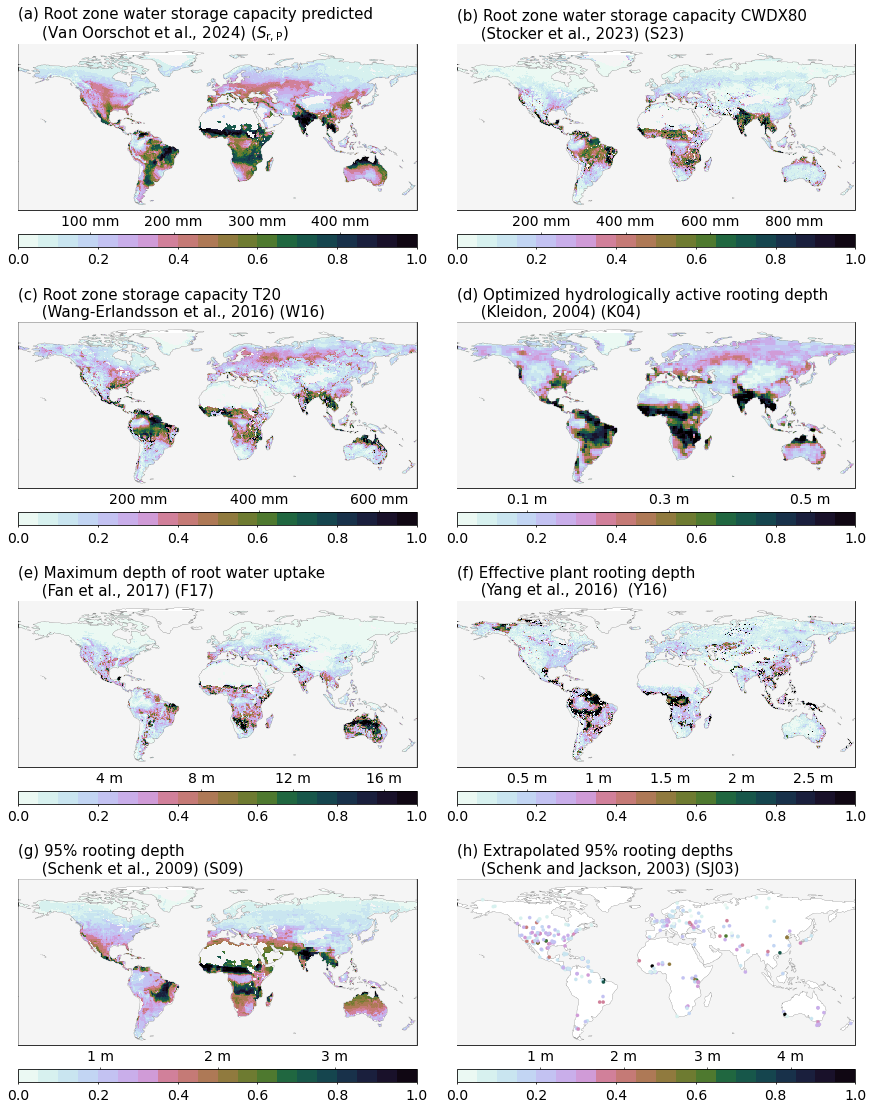

In [12]:
fig, ax = plt.subplots(4,2,figsize=(15,30),subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(hspace=-0.65,wspace=0.1)

for i in range(4):
    for j in range(2):
        m,n = i,j
        ax[m,n].coastlines(linewidth=0.1)
        ax[m,n].add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax[m,n].set_global()
        ax[m,n].set_xlim(-180,180)
        ax[m,n].set_ylim(-60,90)

# Sr predicted
bounds = np.linspace(0,1,21)
bounds2 = np.linspace(0,1,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = p.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_srp, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_srp, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(a) Root zone water storage capacity predicted \n     (Van Oorschot et al., 2024) ($S_\mathrm{r,P}$)',size=15, loc='left')

# Sr Stocker
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,1
a = s.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_s, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_s, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title(f'(b) Root zone water storage capacity CWDX80 \n     (Stocker et al., 2023) (S23)',size=15, loc='left')

# Sr Lan
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,0
a = l.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_l, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_l, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(c) Root zone storage capacity T20 \n     (Wang-Erlandsson et al., 2016) (W16)',size=15, loc='left')

# root depth opt Kleidon
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,1
a = ko.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_k, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_k, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(d) Optimized hydrologically active rooting depth \n     (Kleidon, 2004) (K04)',size=15, loc='left')

# fan
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=2,0
a = f.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_f, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_f, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(e) Maximum depth of root water uptake \n     (Fan et al., 2017) (F17)',size=15, loc='left')

# yang
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=2,1
a = ya.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_y, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_y, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(f) Effective plant rooting depth \n     (Yang et al., 2016)  (Y16)',size=15, loc='left')

# Schenk 2009
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=3,0
a = sc.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_sc, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_sc, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(g) 95% rooting depth \n     (Schenk et al., 2009) (S09)',size=15, loc='left')

# Schenk points
m,n=3,1
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
sp = ax[m,n].scatter(sjj.Longitude,sjj.Latitude,s=12,c=sjj.D95_extrapolated_norm,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.03,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_sjj, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_sjj, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(h) Extrapolated 95% rooting depths \n     (Schenk and Jackson, 2003) (SJ03)',size=15,loc='left')

fig.savefig(f'{fig_dir}/fig07.jpg',bbox_inches='tight',dpi=600)


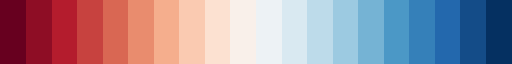

In [13]:
cmap = cm.get_cmap('RdBu', 20)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
cmd = ListedColormap(color_list)
cmd.set_bad('lightgrey')
cmd

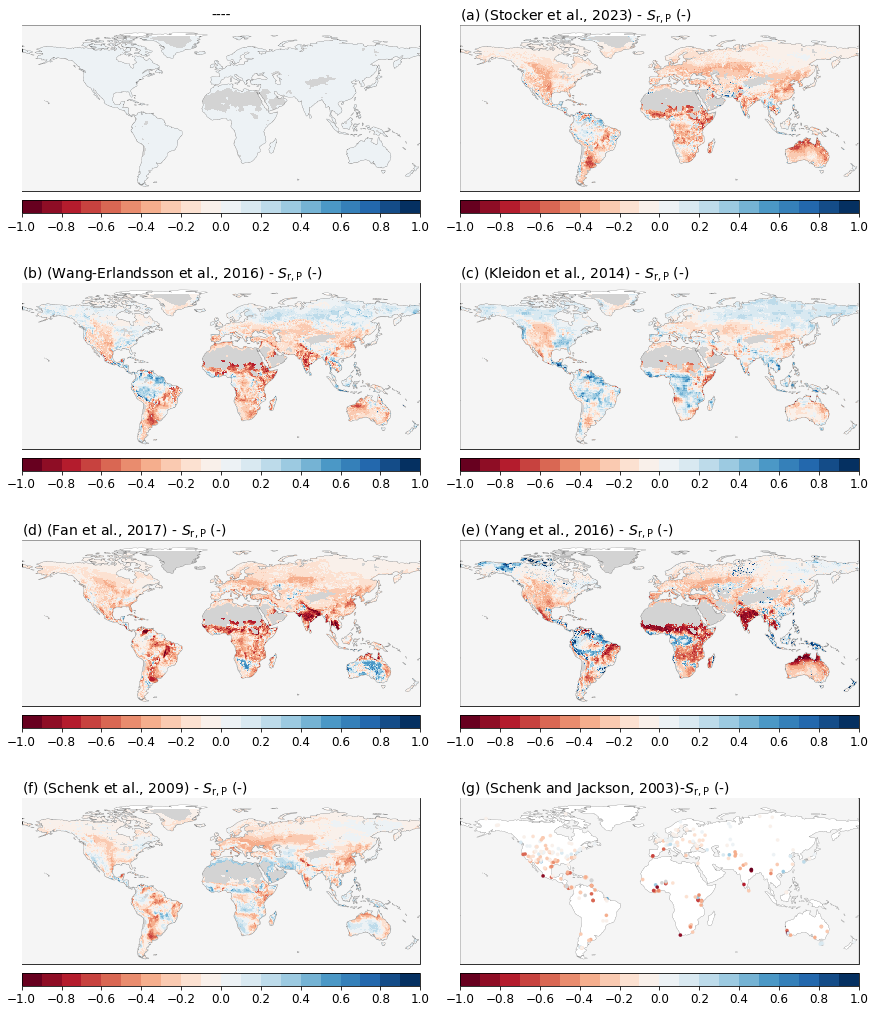

In [14]:
# diff maps
# single figure of maps
fig, ax = plt.subplots(4,2,figsize=(15,30),subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(hspace=-0.7,wspace=0.1)

for i in range(4):
    for j in range(2):
        m,n = i,j
        ax[m,n].coastlines(linewidth=0.1)
        ax[m,n].add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax[m,n].set_global()
        ax[m,n].set_xlim(-180,180)
        ax[m,n].set_ylim(-60,90)

bounds = np.linspace(-1,1,21)
bounds2 = np.linspace(-1,1,11)
# cmd = cm.get_cmap('RdBu')
norm = mpl.colors.BoundaryNorm(bounds, cmd.N)        
        
m,n=0,0
d = p - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('----',size=14)

# Sr Stocker
m,n=0,1
d = s - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(a) (Stocker et al., 2023) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Sr Lan
m,n=1,0
d = l - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(b) (Wang-Erlandsson et al., 2016) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# root depth opt Kleidon
m,n=1,1
d = ko - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(c) (Kleidon et al., 2014) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Fan
m,n=2,0
d = f - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(d) (Fan et al., 2017) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Yang
m,n=2,1
d = ya - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(e) (Yang et al., 2016) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Schenk 2009
m,n=3,0
d = sc - p
a = d.plot(ax=ax[m,n], cmap=cmd,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='',size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(f) (Schenk et al., 2009) - $S_\mathrm{r,P}$ (-)',size=14, loc='left')

# Schenk points
m,n=3,1
d = sjj['D95_extrapolated_norm'] - sjj['sr_p_norm']
sp = ax[m,n].scatter(sjj.Longitude,sjj.Latitude,s=12,c=d,edgecolors='face',marker='o',linewidths=0.1,cmap=cmd,norm=norm,zorder=102)
cbar = plt.colorbar(sp, ax=ax[m,n], orientation='horizontal',spacing='proportional',extend='neither', pad=0.01,aspect=30,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='', size=12)
ax[m,n].set_title('')
ax[m,n].set_title('(g) (Schenk and Jackson, 2003)-$S_\mathrm{r,P}$ (-)',size=14, loc='left')

fig.savefig(f'{work_dir}/output/gridded_sr/figures/global_sr_all_maps_normalized_diff.jpg',bbox_inches='tight',dpi=600)
fig.savefig(f'{fig_dir}/global_sr_diffmaps.jpg',bbox_inches='tight',dpi=600)

## CORRELATIONS

In [16]:
rp_table = compute_corr_tables()[0]
rs_table = compute_corr_tables()[1]

df_rp = pd.DataFrame(data = rp_table,index=['$S_\mathrm{r,P}$ (mm)','Stocker et al. (2023)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'],
                   columns = ['$S_\mathrm{r,P}$ (mm)','Stocker et al. (2023)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Kleidon (2004) (m)','Yang et al. (2016) (m)','Schenk and Jackson (2003) (m)'])
df_rs = pd.DataFrame(data = rs_table,index=['$S_\mathrm{r,P}$ (mm)','Stocker et al. (2023)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'],
                   columns = ['$S_\mathrm{r,P}$ (mm)','Stocker et al. (2023)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'])

In [17]:
# pearson
df_rp

,"$S_\mathrm{r,P}$ (mm)",Stocker et al. (2023),Wang-Erlandsson et al. (2016) (mm),Fan et al. (2017) (m),Schenk et al. (2009) (m),Kleidon (2004) (m),Yang et al. (2016) (m),Schenk and Jackson (2003) (m)
"$S_\mathrm{r,P}$ (mm)",1.00,0.67,0.55,0.56,0.64,-0.01,0.71,0.23
Stocker et al. (2023),0.67,1.00,0.63,0.46,0.52,0.05,0.66,0.11
Wang-Erlandsson et al. (2016) (mm),0.55,0.63,1.00,0.33,0.42,0.06,0.66,0.05
Fan et al. (2017) (m),0.56,0.46,0.33,1.00,0.43,-0.03,0.42,0.12
Schenk et al. (2009) (m),0.64,0.52,0.42,0.43,1.00,0.00,0.57,0.22
Yang et al. (2016) (m),-0.01,0.05,0.06,-0.03,0.00,1.00,-0.02,0.21
Kleidon (2004) (m),0.71,0.66,0.66,0.42,0.57,-0.02,1.00,0.11
Schenk and Jackson (2003) (m),0.23,0.11,0.05,0.12,0.22,0.21,0.11,1.00


In [18]:
# spearman
df_rs

,"$S_\mathrm{r,P}$ (mm)",Stocker et al. (2023),Wang-Erlandsson et al. (2016) (mm),Fan et al. (2017) (m),Schenk et al. (2009) (m),Yang et al. (2016) (m),Kleidon (2004) (m),Schenk and Jackson (2003) (m)
"$S_\mathrm{r,P}$ (mm)",1.00,0.75,0.49,0.76,0.77,-0.00,0.59,0.23
Stocker et al. (2023),0.75,1.00,0.64,0.70,0.72,0.07,0.65,0.15
Wang-Erlandsson et al. (2016) (mm),0.49,0.64,1.00,0.45,0.35,0.03,0.63,0.04
Fan et al. (2017) (m),0.76,0.70,0.45,1.00,0.71,0.04,0.51,0.22
Schenk et al. (2009) (m),0.77,0.72,0.35,0.71,1.00,0.05,0.51,0.21
Yang et al. (2016) (m),-0.00,0.07,0.03,0.04,0.05,1.00,0.06,0.04
Kleidon (2004) (m),0.59,0.65,0.63,0.51,0.51,0.06,1.00,0.12
Schenk and Jackson (2003) (m),0.23,0.15,0.04,0.22,0.21,0.04,0.12,1.00


In [19]:
rpw_table = compute_corr_tables_weighted()[0]
rsw_table = compute_corr_tables_weighted()[1]

df_rpw = pd.DataFrame(data = rpw_table,index=['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'],
                   columns = ['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Kleidon (2004) (m)','Yang et al. (2016) (m)','Schenk and Jackson (2003) (m)'])
df_rsw = pd.DataFrame(data = rsw_table,index=['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'],
                   columns = ['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Fan et al. (2017) (m)','Schenk et al. (2009) (m)','Yang et al. (2016) (m)','Kleidon (2004) (m)','Schenk and Jackson (2003) (m)'])

In [20]:
df_rpw

,Sr_p (mm),Stocker et al. (2023) (mm),Wang-Erlandsson et al. (2016) (mm),Fan et al. (2017) (m),Schenk et al. (2009) (m),Kleidon (2004) (m),Yang et al. (2016) (m),Schenk and Jackson (2003) (m)
Sr_p (mm),1.00,0.63,0.53,0.51,0.60,-0.02,0.70,0.23
Stocker et al. (2023) (mm),0.63,1.00,0.62,0.40,0.47,0.05,0.64,0.11
Wang-Erlandsson et al. (2016) (mm),0.53,0.62,1.00,0.30,0.39,0.07,0.65,0.05
Fan et al. (2017) (m),0.51,0.40,0.30,1.00,0.37,-0.04,0.38,0.12
Schenk et al. (2009) (m),0.60,0.47,0.39,0.37,1.00,-0.00,0.53,0.22
Yang et al. (2016) (m),-0.02,0.05,0.07,-0.04,-0.00,1.00,-0.02,0.21
Kleidon (2004) (m),0.70,0.64,0.65,0.38,0.53,-0.02,1.00,0.11
Schenk and Jackson (2003) (m),0.23,0.11,0.05,0.12,0.22,0.21,0.11,1.00


In [21]:
# change order of columns and rows
df_rsw = df_rsw.reindex(['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Kleidon (2004) (m)','Fan et al. (2017) (m)','Yang et al. (2016) (m)','Schenk et al. (2009) (m)','Schenk and Jackson (2003) (m)'])
df_rsw = df_rsw[['Sr_p (mm)','Stocker et al. (2023) (mm)','Wang-Erlandsson et al. (2016) (mm)','Kleidon (2004) (m)','Fan et al. (2017) (m)','Yang et al. (2016) (m)','Schenk et al. (2009) (m)','Schenk and Jackson (2003) (m)']]
df_rsw

,Sr_p (mm),Stocker et al. (2023) (mm),Wang-Erlandsson et al. (2016) (mm),Kleidon (2004) (m),Fan et al. (2017) (m),Yang et al. (2016) (m),Schenk et al. (2009) (m),Schenk and Jackson (2003) (m)
Sr_p (mm),1.00,0.72,0.48,0.61,0.70,-0.02,0.73,0.23
Stocker et al. (2023) (mm),0.72,1.00,0.66,0.68,0.65,0.08,0.69,0.15
Wang-Erlandsson et al. (2016) (mm),0.48,0.66,1.00,0.64,0.43,0.05,0.32,0.04
Kleidon (2004) (m),0.61,0.68,0.64,1.00,0.51,0.07,0.50,0.12
Fan et al. (2017) (m),0.70,0.65,0.43,0.51,1.00,0.03,0.65,0.22
Yang et al. (2016) (m),-0.02,0.08,0.05,0.07,0.03,1.00,0.04,0.04
Schenk et al. (2009) (m),0.73,0.69,0.32,0.50,0.65,0.04,1.00,0.21
Schenk and Jackson (2003) (m),0.23,0.15,0.04,0.12,0.22,0.04,0.21,1.00


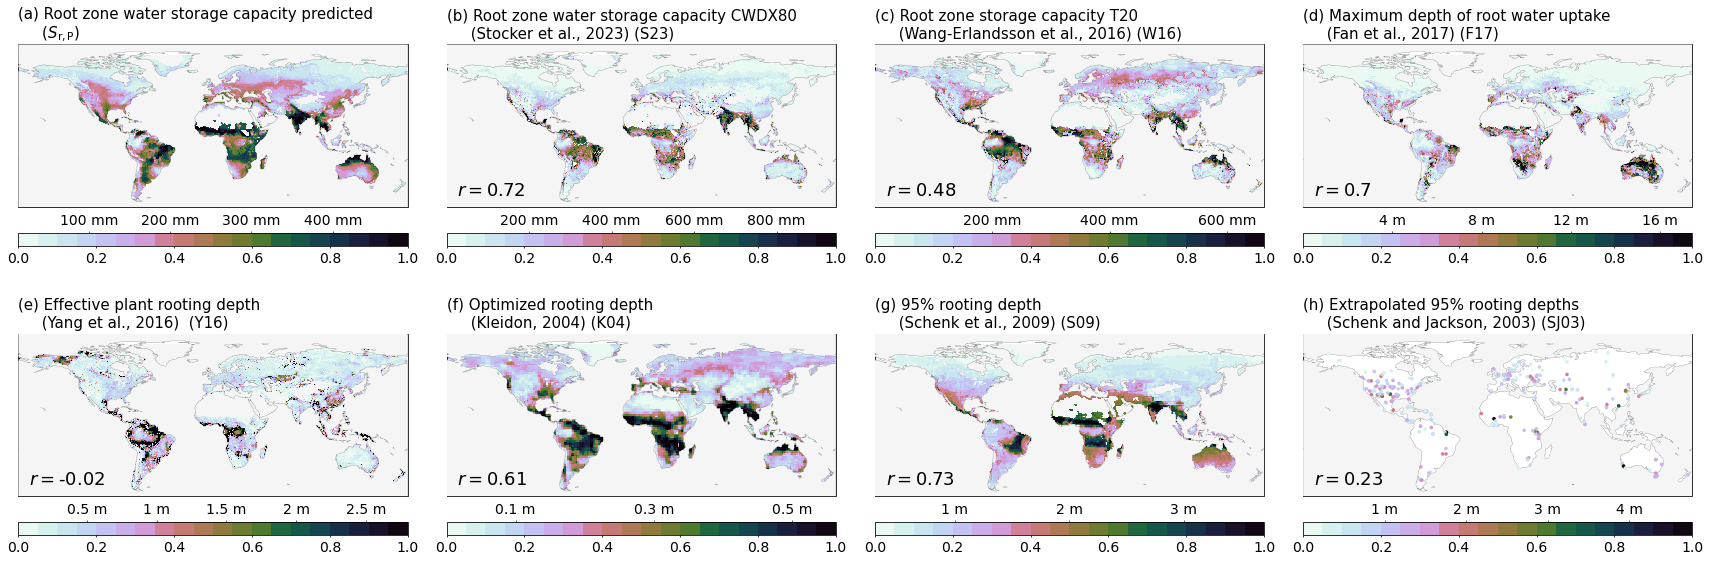

In [23]:
# single figure of maps - PRESENTATION
fig, ax = plt.subplots(2,4,figsize=(30,15),subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(hspace=-0.45,wspace=0.1)

for i in range(2):
    for j in range(4):
        m,n = i,j
        ax[m,n].coastlines(linewidth=0.1)
        ax[m,n].add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
        ax[m,n].set_global()
        ax[m,n].set_xlim(-180,180)
        ax[m,n].set_ylim(-60,90)

# Sr predicted
bounds = np.linspace(0,1,21)
bounds2 = np.linspace(0,1,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,0
a = p.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.05,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_srp, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_srp, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
ax[m,n].set_title('')
ax[m,n].set_title('(a) Root zone water storage capacity predicted \n     ($S_\mathrm{r,P}$)',size=15, loc='left')

# Sr Stocker
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,1
a = s.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.05,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_s, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_s, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
r=df_rsw.loc['Sr_p (mm)','Stocker et al. (2023) (mm)']
ax[m,n].text(-170,-50,f'$r=${r}',size=18,zorder=101)
ax[m,n].set_title('')
ax[m,n].set_title(f'(b) Root zone water storage capacity CWDX80 \n     (Stocker et al., 2023) (S23)',size=15, loc='left')

# Sr Lan
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,2
a = l.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.05,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_l, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_l, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
r=df_rsw.loc['Sr_p (mm)','Wang-Erlandsson et al. (2016) (mm)']
ax[m,n].text(-170,-50,f'$r=${r}',size=18,zorder=101)
ax[m,n].set_title('')
ax[m,n].set_title('(c) Root zone storage capacity T20 \n     (Wang-Erlandsson et al., 2016) (W16)',size=15, loc='left')

# fan
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=0,3
a = f.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.05,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_f, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_f, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
r=df_rsw.loc['Sr_p (mm)','Fan et al. (2017) (m)']
ax[m,n].text(-170,-50,f'$r=${r}',size=18,zorder=101)
ax[m,n].set_title('')
ax[m,n].set_title('(d) Maximum depth of root water uptake \n     (Fan et al., 2017) (F17)',size=15, loc='left')

# yang
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,0
a = ya.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.05,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_y, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_y, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
r=df_rsw.loc['Sr_p (mm)','Yang et al. (2016) (m)']
ax[m,n].text(-170,-50,f'$r=${r}',size=18,zorder=101)
ax[m,n].set_title('')
ax[m,n].set_title('(e) Effective plant rooting depth \n     (Yang et al., 2016)  (Y16)',size=15, loc='left')

# root depth opt Kleidon
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,1
a = ko.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.05,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_k, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_k, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
r=df_rsw.loc['Sr_p (mm)','Kleidon (2004) (m)']
ax[m,n].text(-170,-50,f'$r=${r}',size=18,zorder=101)
ax[m,n].set_title('')
ax[m,n].set_title('(f) Optimized rooting depth \n     (Kleidon, 2004) (K04)',size=15, loc='left')

# Schenk 2009
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
m,n=1,2
a = sc.plot(ax=ax[m,n], cmap=cmap_sr,levels=bounds, add_colorbar=False)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.05,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_sc, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_sc, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
r=df_rsw.loc['Sr_p (mm)','Schenk et al. (2009) (m)']
ax[m,n].text(-170,-50,f'$r=${r}',size=18,zorder=101)
ax[m,n].set_title('')
ax[m,n].set_title('(g) 95% rooting depth \n     (Schenk et al., 2009) (S09)',size=15, loc='left')

# Schenk points
m,n=1,3
norm = mpl.colors.BoundaryNorm(bounds, cmap_sr.N)
sp = ax[m,n].scatter(sjj.Longitude,sjj.Latitude,s=12,c=sjj.D95_extrapolated_norm,edgecolors='face',marker='o',linewidths=0.1,cmap=cmap_sr,norm=norm,zorder=102)
cbar = plt.colorbar(a, ax=ax[m,n],orientation='horizontal',spacing='proportional',extend='neither', pad=0.05,aspect=30)
cbar.ax.xaxis.set_ticks(ticks=bounds2, major=True)
cbar.ax.xaxis.set_ticks(ticks=tl_sjj, minor=True)
cbar.ax.xaxis.set_ticklabels(tll_sjj, minor=True)
cbar.ax.tick_params(which="minor",length=2,labelsize=14, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.ax.tick_params(which="major",length=2,labelsize=14, bottom=True, labelbottom=True)
r=df_rsw.loc['Sr_p (mm)','Schenk and Jackson (2003) (m)']
ax[m,n].text(-170,-50,f'$r=${r}',size=18,zorder=101)
ax[m,n].set_title('')
ax[m,n].set_title('(h) Extrapolated 95% rooting depths \n     (Schenk and Jackson, 2003) (SJ03)',size=15,loc='left')

fig.savefig(f'{fig_dir}/fig07_presentation.jpg',bbox_inches='tight',dpi=600)

In [24]:
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')

f = xr.open_dataset(f'{work_dir}/data/reference_sr/fan/maxroot_allregions_crugrid2.nc') 
f = f.root_depth
f = f.where(p.sr_p[:,:]>=0)

ya = xr.open_dataset(f'{work_dir}/data/reference_sr/yang/data/Effective_Rooting_Depth.nc')
ya = ya.Band1
ya = ya.where(p.sr_p[:,:]>=0)

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_20yrs.nc')
l = l.sr_cru_20yrs[0]
l = l.where(p.sr_p[:,:]>=0)

s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_cru_grid.nc')
s = s.cwdx80
s = s.where(p.sr_p[:,:]>=0)

sc = xr.open_dataset(f'{work_dir}/data/reference_sr/schenk2009/data/processed/95ecosys_rootdepth_1d_crugrid.nc') 
sc = sc['95ecosys_rootdepth_1d'][0]
sc = sc.where(p.sr_p[:,:]>=0)

ka = xr.open_dataset(f'{work_dir}/data/reference_sr/Kleidon rooting depth/rootAssMap150_crugrid.nc')
ka = ka['rootAssMap150_m']
ko = xr.open_dataset(f'{work_dir}/data/reference_sr/Kleidon rooting depth/rootOptMap150_crugrid.nc')
ko = ko['rootOptMap150_m']

#Schenk and Jackson observed rooting depths
sjj = pd.read_csv(f'{work_dir}/data/reference_sr/Schenk+Jackson2003-rootzone-point-data_processed.csv',index_col=0)

In [25]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    # cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    # cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True,labelsize=14)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #          rotation_mode="anchor")
    
    plt.setp(ax.get_xticklabels(), rotation=30, ha="center", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    # ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

272
52025
272
51995
272
53935
272
52655
272
9526
272
51491
307
293


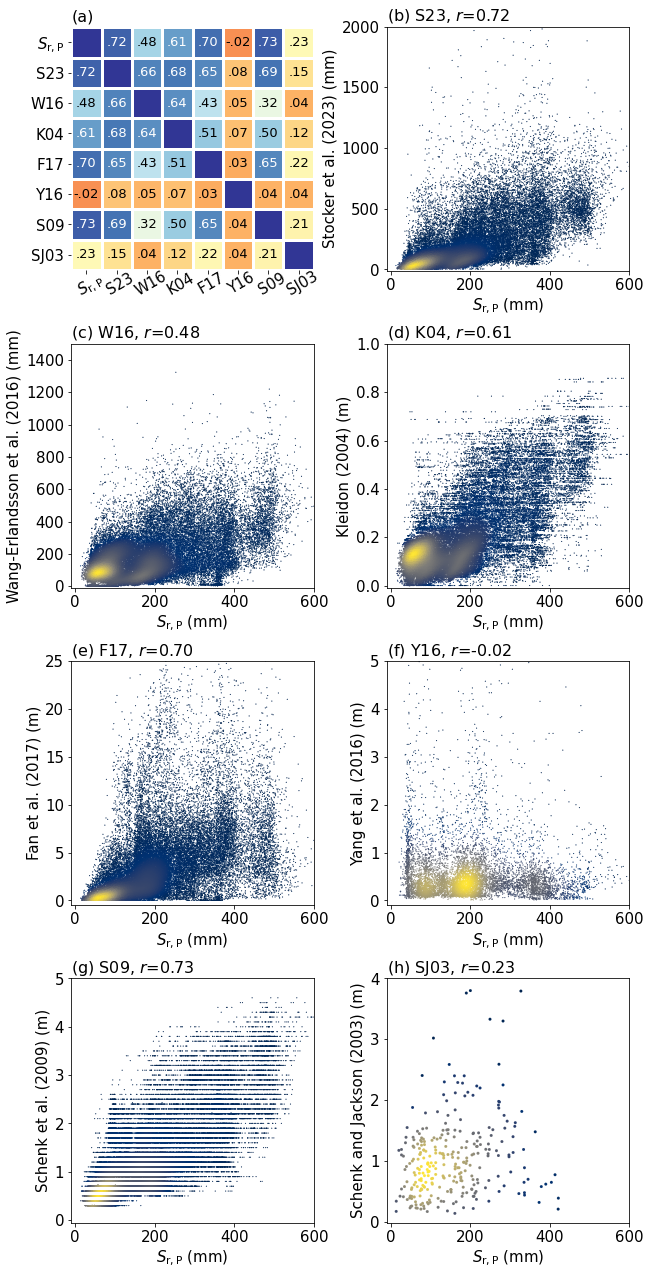

In [27]:
# PLOT

fig = plt.figure(figsize=(10,22))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

xl = ['$S_\mathrm{r,P}$','S23','W16','K04','F17','Y16','S09','SJ03']
yl = ['$S_\mathrm{r,P}$','S23','W16','K04','F17','Y16','S09','SJ03']
corr = df_rsw.copy(deep=True)
ax = fig.add_subplot(421)
im, _ = heatmap(corr, xl,yl, ax=ax,
                cmap="RdYlBu", vmin=-0.3, vmax=0.8)
ax.tick_params(top=False, bottom=True,
               labeltop=False, labelbottom=True,labelsize=15)
def func(x, pos):
    return f"{x:.2f}".replace("0.", ".").replace("1.00", "")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func),threshold=0.6, size=13)
ax.set_title('(a)',size=16,loc='left')


ax = fig.add_subplot(422)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = s
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Stocker et al. (2023) (mm)']
rs = df_rsw.loc['Sr_p (mm)','Stocker et al. (2023) (mm)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-10,2000)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(b) S23, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Stocker et al. (2023) (mm)',size=15)
print(len(x))

ax = fig.add_subplot(423)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = l
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Wang-Erlandsson et al. (2016) (mm)']
rs = df_rsw.loc['Sr_p (mm)','Wang-Erlandsson et al. (2016) (mm)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-10,1500)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(c) W16, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Wang-Erlandsson et al. (2016) (mm)',size=15)
print(len(x))

ax = fig.add_subplot(424)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = ko
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Kleidon (2004) (m)']
rs = df_rsw.loc['Sr_p (mm)','Kleidon (2004) (m)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.01,1)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(d) K04, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Kleidon (2004) (m)',size=15)
print(len(x))

ax = fig.add_subplot(425)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = f
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Fan et al. (2017) (m)']
rs = df_rsw.loc['Sr_p (mm)','Fan et al. (2017) (m)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.5,25)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(e) F17, $r$={rs}0',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Fan et al. (2017) (m)',size=15)
print(len(x))

ax = fig.add_subplot(426)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = ya
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Yang et al. (2016) (m)']
rs = df_rsw.loc['Sr_p (mm)','Yang et al. (2016) (m)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.1,5)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(f) Y16, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Yang et al. (2016) (m)',size=15)
print(len(x))


ax = fig.add_subplot(427)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=p.sr_p
print(len(x))
y = sc
x = x.stack(flat=['lat','lon']).values
y = y.stack(flat=['lat','lon']).values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Schenk et al. (2009) (m)']
rs = df_rsw.loc['Sr_p (mm)','Schenk et al. (2009) (m)']
ax.scatter(x,y,c=z,s=1,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.05,5)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(g) S09, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Schenk et al. (2009) (m)',size=15)
print(len(x))

ax = fig.add_subplot(428)
p = xr.open_dataset(f'{work_dir}/output/gridded_sr/data_xr_mean.nc')
x=sjj.sr_p.values
print(len(x))
y = sjj.D95_extrapolated.values
nan_indices = np.logical_or(np.isnan(x), np.isnan(y))
x[nan_indices] = np.nan
y[nan_indices] = np.nan
x = x[~np.isnan(x)]
y = y[~np.isnan(y)]
kde = gaussian_kde(np.vstack([x, y]))
z = kde(np.vstack([x, y]))
rp = df_rpw.loc['Sr_p (mm)','Schenk and Jackson (2003) (m)']
rs = df_rsw.loc['Sr_p (mm)','Schenk and Jackson (2003) (m)']
ax.scatter(x,y,c=z,s=8,cmap='cividis',linewidth=0.1,edgecolors='face',marker='o')
ax.set_xlim(-10,600)
ax.set_ylim(-0.01,4)
ax.tick_params(axis='both',labelsize=15)
ax.set_title(f'(h) SJ03, $r$={rs}',size=16, loc='left')
ax.set_xlabel('$S_\mathrm{r,P}$ (mm)',size=15)
ax.set_ylabel('Schenk and Jackson (2003) (m)',size=15)
print(len(x))

fig.savefig(f'{fig_dir}/fig08.jpg',bbox_inches='tight',dpi=600)

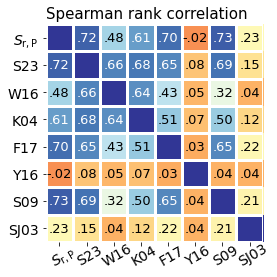

In [58]:
xl = ['$S_\mathrm{r,P}$','S23','W16','K04','F17','Y16','S09','SJ03']
yl = ['$S_\mathrm{r,P}$','S23','W16','K04','F17','Y16','S09','SJ03']

corr = df_rsw.copy(deep=True)
fig, ax = plt.subplots(1,1,figsize=(6,4))
im, _ = heatmap(corr, xl,yl, ax=ax,
                cmap="RdYlBu", vmin=-0.3, vmax=0.8)

def func(x, pos):
    return f"{x:.2f}".replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func),threshold=0.6, size=13)
ax.set_title('Spearman rank correlation',size=15,loc='left')
plt.show()
fig.savefig(f'{fig_dir}/corrmatrix.jpg',bbox_inches='tight',dpi=600)